# Analysis of On Water Tests

# Brief
Herein I generate plots and an analysis from the on water test results, and work towards discovering metrics for automated batch testing, building upon the original template analyze.py script. 

### TODO
Preview plots
 - [x] Change orange waypoint marker to bright blue circle
 - [x] Change the background of the plot to a very subtle gray tone
 - [x] Change to ubuntu or courier font
 
 Detailed plots
 - [x] Get rid of near misses/collisions
 - [x] Change color tones to match the general pallet 
 - [x] Add three leader set plots for (time, in convoy, leader velocity)
 - [x] Make the bar plot spawl the bottom
 - [x] On the right side, we'll have
 - [x] [Desired speed, average speed, and std spread]
 - [x] [Mean deviation from IDF, and STD band for all errors from IDF]
 
 Rerender plots for
 
 - [x] C001_P02906_K2_tn (simulation) - can probably get rid of this plot
 
 Field trial results
 - [x] 20231114_1621_tn
 - [x] 20231114_1621_det
 - [x] 20231118_1213_best1_cpd_tn
 - [x] 20231118_1213_best1_cpd_det
 - [x] 20231127_1547_tn
 - [x] 20231127_1547_det
 
 Stress tests
 - [x] 231209-1145G-LOUD-MERL_tn_ccss
 - [x] 231209-1145G-LOUD-MERL_det_ccss
 - [ ] 231209-1148S-DEEP-SCAN_tn_cpd.png
 - [ ] 231209-1148S-DEEP-SCAN_det_cpd
 - [ ] 231209-1152S-CURT-BEAU_tn_cpds
 - [ ] 231209-1152S-CURT-BEAU_det_cpds
 
 
 
 
 

In [239]:
import sys
import os
import json 
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.path import Path
import warnings
plt.rcParams['font.family'] = 'Ubuntu'
from matplotlib import font_manager
font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
font_manager.findfont("Ubuntu") # Test with "Special Elite" too

warnings.filterwarnings("ignore") #matplotlib and pandas are too verbose

In [240]:

themed_colors = [
                "#FFEBB0", #0: yellow
                "#FAA15A",  #1: orange
                "#9BD79A",  #2: green
                "#5FBFC0",  #3: teal
                "#B3FEFE",  #4: blue
                "#F37B4D",  #5: tangerine
                "#789ABC",  #6: navy
                "#EAEAEA",  #7: gray
                "#5A6E76",  #8: dark gray
                "#6D9898",  #9: gray teal
                 ]


tall_plot = False

### CONVOY CLASSIC
# analysis_type = "cc"
# circuit = "-95,-71 : -68,-136 : 47,-118 : 120,-47 : 93,10"

# mission_directory = "logs/20231114_convoy-baseline/20231114_1621_json/" # Need this one
# trim_lb = 500
# trim_ub = 2000
# desired_speed_fm = 1.2
# idf = 12



### CONVOY PD
analysis_type = "cpd"
circuit = "-72,-67:-44,-133:40,-120:92,-65:63,-3"
idf = 10

# mission_directory = "logs/20231117_convoypd/convoy_pd_main_json/"
# trim_lb = 0
# trim_ub = 2000


# mission_directory = "logs/20231117_convoypd/test_3_json/"
# trim_lb = 0
# trim_ub = 2000


# mission_directory = "logs/20231118_convoypd/20231118_1213_best1_json/" # Need this one [done]
# trim_lb = 0
# trim_ub = 1050
# desired_speed_fm = 1.4

# mission_directory = "logs/20231118_convoypd/20231118_1151_best2_json/"
# trim_lb = 0
# trim_ub = 900

# mission_directory = "logs/20231127_convoypdsync/20231127_0940_json/"
# trim_lb = 0
# trim_ub = 800

# mission_directory = "logs/20231127_convoypdsync/20231127_1124_json/"
# trim_lb = 0
# trim_ub = 2000

mission_directory = "logs/20231127_convoypdsync/20231127_1547_json/" # Need this one [done]
trim_lb = 0
trim_ub = 1000
desired_speed_fm = 1.2

## Zig zag stress test
# tall_plot = True
# circuit = "30,-20:0,-50:60,-60:0,-80:60,-90:0,-110:60,-120:0,-140"
# desired_speed_fm = 1.2
# analysis_type = "cc"

# # mission_directory = "logs/20231209_sim_ss/231209-1145G-LOUD-MERL_json" 
# mission_directory = "logs/20240219_sim_ss/240219-1928S-LATE-HALO_cc"
# mission_directory = "logs/20240224_sim_ss/240224-2121U-SURE-HANS_json"
# idf = 10
# trim_lb = 0
# trim_ub = 2000


# analysis_type = "cpd"

# No Sync
# mission_directory = "logs/20231209_sim_ss/231209-1148S-DEEP-SCAN_json" 
# mission_directory = "logs/20240219_sim_ss/240219-2025A-TAME-CODY_cpd"
# mission_directory = "logs/20240224_sim_ss/240224-2148E-POSH-MITT_json"
# trim_lb = 0
# trim_ub = 4000

#Sync
# mission_directory = "logs/20231209_sim_ss/231209-1152S-CURT-BEAU_json" 
# mission_directory = "logs/20240219_sim_ss/240219-1915X-EASY-TACK_cpds"
# mission_directory = "logs/20240224_sim_ss/240224-2155I-FOND-NYLE_json"
# mission_directory = "logs/20240224_sim_ss/240224-2210Q-DARK-SHIN_json"
# trim_lb = 0
# trim_ub = 4000


glb = glob.glob(f"{mission_directory}/*.json")
fname = glb[0]
variable_file = "plug_bhv_variables.moos"
mission_data = json.load(open(fname))


In [241]:
if mission_directory[-1] == "/":
    mission_directory = mission_directory[:-1]
mission_hash = mission_directory.split("/")[-1]    
mission_hash = mission_hash.replace("_json","")
glb = glob.glob(f"{mission_directory}/*.json")
fname = glb[0]

In [242]:
output_directory = f"{mission_directory}/"
output_directory = output_directory.replace("_json","")
try:
    os.mkdir(output_directory)
except OSError:
    pass 
    #print(f"Creation of the directory {path} failed")

# TODO: Make color mapping based on the ordering of agents
color_mapping = {"abe":"y",
                 "ben":"r",
                 "eve":"g",
                 "deb":"m",
                 "fin":"b",
                 "cal":"b"}

In [243]:
circuit = circuit.replace(" ","")
circuit = circuit.split(":")
split_point = lambda point: [float(v) for v in point.split(',')]
circuit = [split_point(point) for point in circuit]
circuit_turns = 0
first_leg_angle = 0
lap_length = 0
for idx in range(2,len(circuit)):
    p_1 = circuit[idx-2]
    p_2 = circuit[idx-1]
    p_3 = circuit[idx]

    leg1_angle = np.arctan2(p_2[1]-p_1[1],p_2[0]-p_1[0])*180/np.pi
    leg2_angle = np.arctan2(p_3[1]-p_2[1],p_3[0]-p_2[0])*180/np.pi

    #Assume the agent took the shortest closure distance
    turn_angle = (leg2_angle-leg1_angle+180)%360 - 180
    if(idx == 2):
        first_leg_angle = turn_angle        
    circuit_turns+=abs(turn_angle)

for idx in range(1,len(circuit)):
    p1 = circuit[idx]
    p0 = circuit[idx-1]
    lap_length+=np.sqrt((p1[0] - p0[0])**2 + (p1[1] - p0[1])**2)

legend_markers = ["Waypoints"]

In [244]:
agent_names = []
agent_info = dict()
all_general_info = dict()
agent_start_pos = []
agent_distances = []

#Get the parameters we are varying from configuration file
#variable_file_1 = "plug_bhv_variables.moos"
agent_variables = dict()
stripped_chars = [" ","\n","\r","\t"]

if analysis_type == "cc":
    with open(variable_file, 'r') as f:
        while(True):    
            line = f.readline()
            if line == "":
                break 
            else: 
                #Strip all comments out of the line, i.e. everything to the right of a //
                idx = line.find("//")
                if idx != -1:
                    line = line[0:idx]
                    if len(line) == 0:
                        continue
                for c in stripped_chars:
                    line = line.replace(c,"")
                line = line.split("=")
                agent_variables[line[0]] = line[1]    

## 1) Extracts all the data from the JSON file, while converting data to the write type
## 2) Data is stored into a list for now, unsynchronized, and is later time synchronized

all_agent_data = []
shoreside_data = pd.DataFrame()
node_report_col_names = ["TIME","X","Y","HDG","SPD"]
node_report_types = ["f","f","f","f","f"]



all_vars = []
all_vars.extend(node_report_col_names)
all_vars = [f.lower() for f in all_vars]
all_var_types = []
all_var_types.extend(node_report_types)

type_mapping = dict(zip(all_vars,all_var_types))

def cast(var,dat):
    var = var.lower()
    if(var == "f" or type_mapping[var] == "f"):
        return float(dat)
    elif(var == "i" or type_mapping[var] == "i"):
        return int(dat)
    elif(var == "s" or type_mapping[var] == "s"):
        return str(dat)

#Extract all the data we care about from the JSON file
for key, val in mission_data.items():
    if(key.find("SHORESIDE") > 0):
        #Collect near collision information
        data = val["data"]
        ct = "COLLISION_TOTAL"
        pre_df_tc = [[i[0], float(i[1])] for i in data[ct]]
        #incrementing_total_near_misses = data["NEAR_MISS_TOTAL"] #A list of [time, data[dict_keys], source]
        nm = "NEAR_MISS_TOTAL"
        pre_df_nm = [[i[0], float(i[1])] for i in data[nm]]

        ss_df1 = pd.DataFrame(pre_df_tc,columns=["time", "collision_total"]).set_index("time")
        ss_df2 = pd.DataFrame(pre_df_nm,columns=["time", "near_miss_total"]).set_index("time")

        ss_group = [ss_df1,ss_df2]

        shoreside_data = ss_group.pop()

        for s in ss_group:
            shoreside_data = shoreside_data.join(s,how="outer")
    else:
        #For each agent, we are going to capture all information we are interested in
        agent_name = key
        agent_name = agent_name.replace("LOG_","")
        idx = agent_name.find("_")
        agent_name = agent_name[0:idx].lower()
        legend_markers.append(agent_name)
        agent_names.append(agent_name)
        data = val["data"]

        #Get all the data we care about from node reports
        node_reports = data["NODE_REPORT_LOCAL"]

        #Prepends the agent name to the node report name, makes it lower case to be consistent
        # further, time will be the same
        col_names = [f"{agent_name}_{t}".lower() if t != "TIME" else t.lower() for t in node_report_col_names]

        #Unpacks the data we want from the node report
        nr_agent_pre_df = [[cast(n,v[1][n]) for n in node_report_col_names] for v in node_reports]

        #Occasional issues in which DESIRED_RUDDER and DESIRED_THRUST nondeterministically exist, temporary fix until a real solution is found
        if "DESIRED_RUDDER" in data.keys():
            rddr = [[entry[0],cast("f",entry[1])] for entry in data["DESIRED_RUDDER"]]
        else:
            rddr = [[entry[0],0] for entry in data["NODE_REPORT_LOCAL"]]
        rddr_df = pd.DataFrame(rddr, columns=["time", f"{agent_name}_rudder"]).set_index("time")
        if "DESIRED_THRUST" in data.keys():
            thrust = [[entry[0],cast("f",entry[1])] for entry in data["DESIRED_THRUST"]]
        else:
            thrust = [[entry[0],0] for entry in data["NODE_REPORT_LOCAL"]]
        thrust_df = pd.DataFrame(thrust, columns=["time", f"{agent_name}_thrust"]).set_index("time")
        
        trim_lb = data["DEPLOY"][-1][0]
        
        if analysis_type == "cpd":
            if "ORDERING" in data.keys():
                ordering = data["ORDERING"][-1][1].split("|")


        #Puts all the data now in the collection of dataframes still awaiting to be merged
        agent_df = pd.DataFrame(nr_agent_pre_df,columns=col_names).set_index("time")

        agent_df = agent_df.join(rddr_df,how='outer')
        agent_df = agent_df.join(thrust_df,how='outer')

        #We assume ZOH, in the sense that a message to the MOOSDB is the start of a new state
        # fill forward
        #agent_df.fillna(method='ffill',inplace=True)

        #All NaNs that remain, is in the very start of the mission when agents are being brought online, such that 
        # no data exists to be filled forward (drop it)
        #agent_df.dropna(inplace=True)

        all_agent_data.append(agent_df.copy())

        slower_rng = 0
        ideal_rng = 0
        faster_rng = 0
        full_lag_rng = 0
        following = "na"
        #TODO: Extract agents convoy/speed policy
        if analysis_type == "cc":
            if 'type=waypoint' not in data["TASK_WON"][-2][1]:
                is_leader = False
            else:
                is_leader = True
                all_general_info["leader"] = agent_name
        else:
            if agent_name == ordering[0]:
                is_leader = True
                all_general_info["leader"] = agent_name
            else:
                is_leader = False
                        

        if is_leader:
            pass
        else:
            if analysis_type == "cc":
                spd_policy_str = data["CONVOY_SPD_POLICY"][0][1]
                all_items = spd_policy_str.split("|")
                all_items = [k.split("=") for k in all_items]
                spd_policy = dict(all_items)
                slower_rng = float(spd_policy["slower_rng"])
                ideal_rng = float(spd_policy["ideal_rng"])
                faster_rng = float(spd_policy["faster_rng"])
                full_lag_rng = float(spd_policy["full_lag_rng"])

            task_convoy = data["TASK_WON"][-1][1]

            all_items = dict([k.split("=") for k in task_convoy.split("|")])
            following = all_items["id"]
            following = following.replace("follow_","")


        color = color_mapping[node_reports[0][1]["NAME"]]

        agent_info[agent_name] = {"slower_rng":slower_rng,
                                  "ideal_rng":ideal_rng,
                                    "faster_rng":faster_rng,
                                    "full_lag_rng":full_lag_rng,
                                    "color":color,
                                    "is_leader":is_leader,
                                    "following":following}


In [245]:
lead = all_general_info["leader"]
all_general_info["ordering"] = {lead:1}
idx = 2
found = [lead]

for idx in range(2,len(agent_names)):
    for name_1, v1 in agent_info.items():
        if name_1 in found:
            continue 
        else:
            #Find who is following this lead
            if v1['following'] == lead:
                all_general_info["ordering"].update({name_1:idx})
                found.append(name_1)
                lead = name_1
                break

#Nobody is following the last agent, so we need to infer their order
tail = [names for names in agent_names if names not in found]
all_general_info["ordering"].update({tail[0]:idx+1})
all_general_info["ordering"]
for agent in agent_info:
    agent_info[agent]["color"] = themed_colors[all_general_info["ordering"][agent]-1]
    print(agent_info[agent]["color"])

#FAA15A
#B3FEFE
#9BD79A
#FFEBB0
#5FBFC0


In [246]:
all_data_df = shoreside_data.copy()
for df in all_agent_data:
    all_data_df = all_data_df.join(df,how='outer')
    
#We assume ZOH, in the sense that a message to the MOOSDB is the start of a new state
# fill forward
all_data_df.fillna(method='ffill',inplace=True)

#All NaNs that remain, is in the very start of the mission when agents are being brought online, such that 
# no data exists to be filled forward (drop it)
all_data_df.dropna(inplace=True)

#Check to make sure all time rows are monotonically increasing

#TODO: Add the time differences as its own column
all_data_df = all_data_df.sort_index()
#all_data_df.sort_values(all_data_df.index, axis=0)

#Base everything w/rt mission start
tbegin = all_data_df.index[0]
trim_lb -= tbegin
all_data_df.index = all_data_df.index - tbegin
all_data_df.dropna(inplace=True) #We only care about what happens when all agents are connected
all_data_df = all_data_df.iloc[all_data_df.index < trim_ub]
all_data_df = all_data_df.iloc[all_data_df.index > trim_lb]
t_diff = pd.DataFrame(all_data_df.index).diff().set_index(all_data_df.index).fillna(0)

In [247]:
# Not really analysis, but update the legend markers for the main thumbnail to include the name and order
#legend_markers=agent_names[:]
for idx,name in enumerate(legend_markers):
    if idx == 0:
        continue
    else:
        #TODO: Check this for occasional errors
        try:
            legend_markers[idx]=f"{name}_{all_general_info['ordering'][name]}"
        except:
            print("had an issue with this command")
            print(all_general_info['ordering'])
            legend_markers[idx]=f"{name}_{all_general_info['ordering'][name]}"

            exit(1)

In [248]:
print(legend_markers)
print(agent_names)
print(all_general_info['ordering'])

['Waypoints', 'abe_2', 'deb_5', 'ben_3', 'eve_1', 'fin_4']
['abe', 'deb', 'ben', 'eve', 'fin']
{'eve': 1, 'abe': 2, 'ben': 3, 'fin': 4, 'deb': 5}


In [249]:
def dilate(series):
    return True if series.sum() > 0 else False


#For each follower agent, we are going to look at who they are supposed to be following, and track their distance
for n in agent_names:
    if n == all_general_info["leader"]:
        continue
    following = agent_info[n]["following"]

    rng = all_data_df[[f"{n}_x",
                         f"{n}_y",
                         f"{following}_x",
                         f"{following}_y"]]
 
    rng["dist"] = np.sqrt(np.power(rng[f"{n}_x"]-rng[f"{following}_x"],2)+np.power(rng[f"{n}_y"]-rng[f"{following}_y"],2))
    if analysis_type == "cc":
        all_data_df[f"{n}_trgt_rng"] = rng["dist"] #Target Range
        all_data_df[f"{n}_in_rng"] = (rng["dist"] < (agent_info[n]["ideal_rng"]+4)) & (rng["dist"] > (agent_info[n]["ideal_rng"]-4)) # In Convoy Range
        all_data_df[f"{n}_rng_dev"] = rng["dist"] - agent_info[n]["ideal_rng"] # Agents deviation from desired range
    elif analysis_type == "cpd":
        all_data_df[f"{n}_trgt_rng"] = rng["dist"] #Target Range
        all_data_df[f"{n}_in_rng"] = (rng["dist"] < 14) & (rng["dist"] > 6) # In Convoy Range
        all_data_df[f"{n}_rng_dev"] = rng["dist"] - 10 # Agents deviation from desired range
        
    all_data_df[f"{n}_in_rng"] = all_data_df[f"{n}_in_rng"].rolling(window=3,min_periods=1).apply(dilate) > 0

    #Capture whether or not an agent is entering or exiting convoy range
    all_data_df[f"{n}_entered_convoy"] = all_data_df[f"{n}_in_rng"].astype(int).diff()

#Now that we have all the agents ranging information to the target, identify the times in which all the agents are in range (in the intended convoy)
all_data_df[f"all_in_range"] = True
for n in agent_names:
    if n == all_general_info["leader"]:
        continue
    all_data_df[f"all_in_range"] &= all_data_df[f"{n}_in_rng"]

In [250]:
#We have whether or not all the agents are now in range of their desired convoy, now we can identify when they transition in and out of convoying
# Assume these conditions are integers, mask the transitions such that 1 0 0 0 1 means it is in convoy, leaves convoy, reenters convoy
# Now the derivative provides flags [na -1 0 0 1], where we can now identify exactly when it enters a convoy, rather than just that it
# is in a convoy
# i.e. we can count how many times it entered and exited a convoy (should be fairly redundant)
all_data_df[f"all_in_range_transition"] = all_data_df[f"all_in_range"].astype(int).diff()

In [251]:
#Find out the point to point distances for each agent and the total odometry of the agent
# Divide the point to point distance total odometry 
agent_straightnesses = dict()
agent_odometries = dict()

# Observe the necessary turns and distance an agent would have had to do to complete the circuit
# Divide the necessary turns by the actual turns
agent_turninesses = dict()

leader = all_general_info["leader"]

ss_post_init_data = all_data_df[all_data_df.index > 30]
for n in agent_names:
    hdgs = ss_post_init_data[f"{n}_hdg"].to_numpy()
    x_start = ss_post_init_data[f"{n}_x"].iloc[0]
    y_start = ss_post_init_data[f"{n}_x"].iloc[0]
    hdg_start = hdgs[0]

    x_diffs = ss_post_init_data[f"{n}_x"].diff().to_numpy()[1:]
    y_diffs = ss_post_init_data[f"{n}_y"].diff().to_numpy()[1:]
    odometry = 0
    for idx in range(1,len(x_diffs)):
        odometry+=np.linalg.norm([x_diffs[idx]-x_diffs[idx-1],y_diffs[idx]-y_diffs[idx-1]])
    agent_odometries[n] = odometry + (all_general_info['ordering'][n]-1)*idf
    agent_turninesses[n] =  np.sum(np.abs(((np.diff(hdgs)+180)%360 - 180)))
        
    if n == leader:
        leader_odometry = agent_odometries[n]
        leader_turniness = agent_turninesses[n]
    
for n in agent_names:
    # Stability Proxy 1: Straightness - How must unnecessary distance does the agent cover? This would characterize its efficiency, where 1 is best
    agent_straightnesses[n] = min([leader_odometry/agent_odometries[n],1])

    # Stability Proxy 2: "Turny-ness" - does the agent oscillate, i.e. turn more than what is strictly necessary?. 1 is best (likely unachievable)
    agent_turninesses[n] = min([leader_turniness/agent_turninesses[n],1])

#These measures should be highly correlated, and essentially redundant measures
straightness_index = np.mean([v for k,v in agent_straightnesses.items() if k is not leader]) #Batshelet, Benhamou?
turn_index = np.mean([v for k,v in agent_turninesses.items() if k is not leader])

In [252]:
agent_straightnesses

{'abe': 0.9819686498967685,
 'deb': 0.9490392746818815,
 'ben': 0.9647516992603379,
 'eve': 1.0,
 'fin': 0.9462179882091253}

In [253]:
turn_index

0.6635551489400764

In [254]:
agent_turninesses

{'abe': 0.6713077269480416,
 'deb': 0.6677240423284917,
 'ben': 0.6626411609397573,
 'eve': 1.0,
 'fin': 0.6525476655440146}

In [255]:
# ###### <Main high level thumbnail plot>
# ##### Compose summarization plot for mission
# #Instantiage a plot, optionally lod the MIT sailing pavilion
# fig_tn = plt.figure()
# fig_tn.set_figheight(6)
# fig_tn.set_figwidth(6)

# #All agents thumbnail
# ax1_tn = plt.subplot2grid(shape=(4,4),loc=(0,0),rowspan=4,colspan=4)

# #Text summary
# #ax2_tn = plt.subplot2grid(shape=(4,2),loc=(3,0),rowspan=1,colspan=1)    

# #img = plt.imread("/Users/raymondturrisi/svn/moos-ivp/ivp/data/MIT_SP.tif")
# #ax.imshow(img,extent=[-550, 600, -494, 215])

# #Plot the target waypoints
# ax1_tn.set_facecolor('#cfe2f326')
# ax1_tn.plot([x for x,y in circuit], [y for x,y in circuit], 
#         marker='o',
#         markersize=10,
#         markeredgewidth=3,
#         markerfacecolor="#b3fefeff",
#         markeredgecolor="k",
#         linestyle='None',
#         zorder= 21)

# #Plot the master thumbnail for the mission
# for idx, n in enumerate(agent_names):
#     if agent_info[n]["is_leader"]:
#         print(n)
#         ax1_tn.plot(all_data_df[f"{n}_x"],all_data_df[f"{n}_y"],
#                 agent_info[n]["color"],
#                 linestyle=":",
#                 zorder= 20,
#                 linewidth=4)
#     else:
#         ax1_tn.plot(all_data_df[f"{n}_x"],all_data_df[f"{n}_y"],
#                 agent_info[n]["color"],
#                 linestyle="-",
#                 linewidth=3)

# vertices = [(0, 0), (-1, 1), (1, 1), (2, 0), (1, -1), (-1, -1), (0, 0)]
# codes = [1,2,2,2,2,2,79]
# p = Path(vertices,codes)

# for idx, n in enumerate(agent_names):
#     hdgs = all_data_df[f"{n}_hdg"].to_numpy()
#     hdg_start = hdgs[0]
#     #hdg_start = all_data_df[f"{n}_hdg"][0].iloc[0]
#     x_start = all_data_df[f"{n}_x"].iloc[0]
#     y_start = all_data_df[f"{n}_y"].iloc[0]
#     m = matplotlib.markers.MarkerStyle(p)
#     m._transform = m.get_transform().rotate_deg(hdg_start)
#     color = agent_info[n]["color"]
#     ax1_tn.scatter(x_start,y_start,marker=m,s=150,c=color,zorder=100)

# ax1_tn.set_aspect('equal',adjustable='box')
# #ax1_tn.set_title(f"Mission <{mission_directory}>")
# ax1_tn.grid(True)
# ax1_tn.set_xlabel("Easting (m)")
# ax1_tn.set_ylabel("Northing (m)")
# ax1_tn.legend(legend_markers,ncols=2,borderpad=0)

# #Now we add a little summary within the plot
# if "collision_total" not in all_data_df.columns:
#     collisions = -1
#     near_misses = -1
# else:
#     collisions = all_data_df['collision_total'].iloc[-1]
#     near_misses = all_data_df['near_miss_total'].iloc[-1]
    

    
# scores=f"collisions={collisions:0.0f}"
# scores+=f", near_misses={near_misses:0.0f}"
# scores+=f",\nsi={straightness_index:0.2f}"
# scores+=f", ti={turn_index:0.2f}"
# print(scores)
# fig_tn.canvas.draw_idle()
# plt.savefig(f"{output_directory}{mission_hash}_tn.png", dpi=150)
# plt.show()
# plt.close()
# ###### </Main high level thumbnail plot>

eve


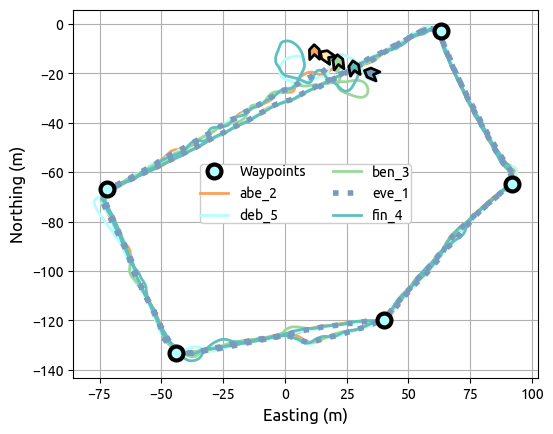

In [256]:
###### <Main high level thumbnail plot>
##### Compose summarization plot for mission
#Instantiage a plot, optionally lod the MIT sailing pavilion
fig_tn = plt.figure()
fig_tn.set_figheight(6)
fig_tn.set_figwidth(6)

#All agents thumbnail
ax1_tn = plt.subplot2grid(shape=(4,4),loc=(0,0),rowspan=4,colspan=4)

#Text summary
#ax2_tn = plt.subplot2grid(shape=(4,2),loc=(3,0),rowspan=1,colspan=1)    

#img = plt.imread("/Users/raymondturrisi/svn/moos-ivp/ivp/data/MIT_SP.tif")
#ax.imshow(img,extent=[-550, 600, -494, 215])

#Plot the target waypoints
ax1_tn.set_facecolor('white')
ax1_tn.plot([x for x,y in circuit], [y for x,y in circuit], 
        marker='o',
        markersize=10,
        markeredgewidth=3,
        markerfacecolor="#b3fefeff",
        markeredgecolor="k",
        linestyle='None',
        zorder= 21)

#Plot the master thumbnail for the mission
for idx, n in enumerate(agent_names):
    if agent_info[n]["is_leader"]:
        print(n)
        ax1_tn.plot(all_data_df[f"{n}_x"],all_data_df[f"{n}_y"],
                color="#789ABC",
                linestyle=":",
                zorder= 20,
                linewidth=4)
    else:
        ax1_tn.plot(all_data_df[f"{n}_x"],all_data_df[f"{n}_y"],
                color=agent_info[n]["color"],
                linestyle="-",
                linewidth=2)

vertices = [(0, 0), (-1, 1), (1, 1), (2, 0), (1, -1), (-1, -1), (0, 0)]
codes = [1,2,2,2,2,2,79]
p = Path(vertices,codes)

for idx, n in enumerate(agent_names):
    hdgs = all_data_df[f"{n}_hdg"].to_numpy()
    hdg_start = hdgs[0]
    #hdg_start = all_data_df[f"{n}_hdg"][0].iloc[0]
    x_start = all_data_df[f"{n}_x"].iloc[0]
    y_start = all_data_df[f"{n}_y"].iloc[0]
    m = matplotlib.markers.MarkerStyle(p)
    m._transform = m.get_transform().rotate_deg(hdg_start)
    color = agent_info[n]["color"] if idx != 1 else "#789ABC"
    ax1_tn.scatter(x_start,y_start,
                   marker=m,
                   s=200,
                   c=color,
                   zorder=100,
                   edgecolors="k",
                   linewidth=2)

ax1_tn.set_aspect('equal',adjustable='box')
#ax1_tn.set_title(f"Mission <{mission_directory}>")
ax1_tn.grid(True)
ax1_tn.set_xlabel("Easting (m)",fontsize=12)
ax1_tn.set_ylabel("Northing (m)",fontsize=12)

if tall_plot == False:
    ax1_tn.legend(legend_markers,ncols=2,borderpad=0,facecolor="white",framealpha=1)
else:
    ax1_tn.legend(legend_markers,
                  ncols=1,
                  borderpad=0,
                  facecolor="white",
                  framealpha=1,
                  loc="center right",
                  bbox_to_anchor=(1.5,0.5))

fig_tn.canvas.draw_idle()
plt.savefig(f"{output_directory}{mission_hash}_tn.png", dpi=300)
plt.show()
plt.close()
###### </Main high level thumbnail plot>

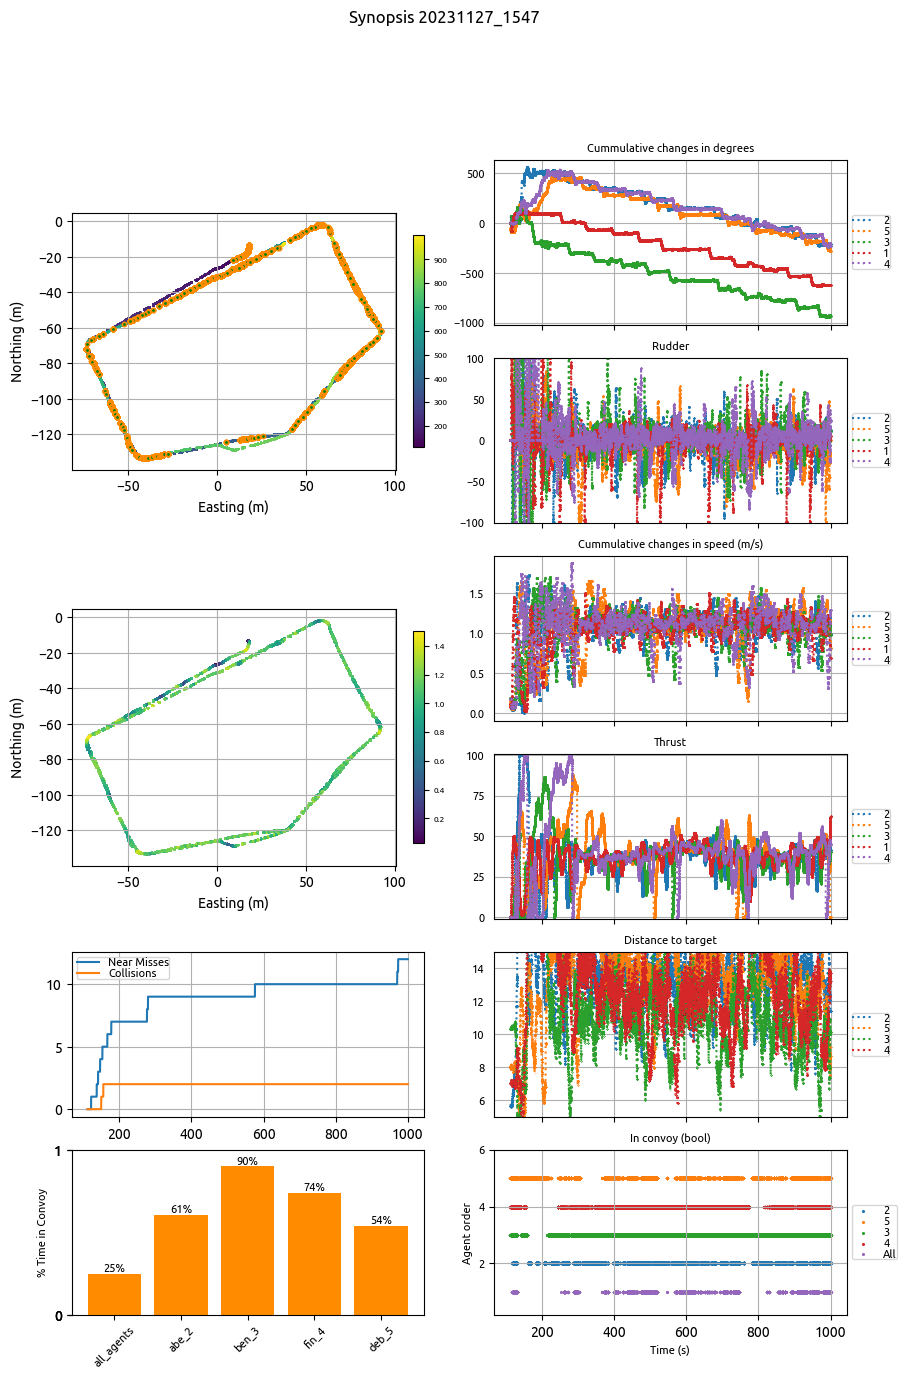

In [257]:
###### <Detailed analysis driven plot>
fig_det = plt.figure()
fig_det.set_figheight(15)
fig_det.set_figwidth(10)

### Left hand side
#Leader's track w/rt to time
ax_leader_det = plt.subplot2grid(shape=(6,2),loc=(0,0),rowspan=2,colspan=1)

#Leader's velocity w/rt to time
ax_leader_vel_det = plt.subplot2grid(shape=(6,2),loc=(2,0),rowspan=2,colspan=1)

#Near misses/collisions w/rt time
ax_nm_and_cols_det = plt.subplot2grid(shape=(6,2),loc=(4,0),rowspan=1,colspan=1)

#Plot a histogram of the agents name/order and the total time they spent in a convoy
ax_perc_in_convoy_det = plt.subplot2grid(shape=(6,2),loc=(5,0),rowspan=1,colspan=1)

### Right hand side (all time sync'd)
#Heading differences for all agents (communicate lag and stability roughly) w/rt time
ax_heading_det = plt.subplot2grid(shape=(6,2),loc=(0,1),rowspan=1,colspan=1)

#Plot desired rudder
ax_rudder_det = plt.subplot2grid(shape=(6,2),loc=(1,1),rowspan=1,colspan=1)

#Speed differences for all agents (communicate lag and stability roughly) w/rt time
ax_spd_chngs_det = plt.subplot2grid(shape=(6,2),loc=(2,1),rowspan=1,colspan=1)

#Plot desired thrust
ax_thrust_det = plt.subplot2grid(shape=(6,2),loc=(3,1),rowspan=1,colspan=1)

#Range to target
ax_rng_to_trg_det = plt.subplot2grid(shape=(6,2),loc=(4,1),rowspan=1,colspan=1)

#Plot horizontal bands for the times in which all the agents are in a convoy
ax_in_convoy_det = plt.subplot2grid(shape=(6,2),loc=(5,1),rowspan=1,colspan=1)


#Plot the leaders trajectory w/rt to time and the times in which the collection of systems is in a convoy
ln = all_general_info["leader"]
leader_x = all_data_df[f"{ln}_x"]
leader_y = all_data_df[f"{ln}_y"]
sc = ax_leader_det.scatter(leader_x,leader_y,c=all_data_df.index,s=0.5)
cbar = plt.colorbar(sc,fraction=0.03)
cbar.ax.tick_params(labelsize=6)
ax_leader_det.set_aspect('equal',adjustable='box')
ax_leader_det.set_xlabel("Easting (m)",fontsize=10)
ax_leader_det.set_ylabel("Northing (m)",fontsize=10)
#ax_leader_det.set_title("Leader Trajectory and Instances in Convoy",fontsize=10)

#get the indices in which all the agents are in a successful convoy
team_convoying = (all_data_df["all_in_range"] == True)
good_convoy_x = leader_x[team_convoying]
good_convoy_y = leader_y[team_convoying]
ax_leader_det.plot(good_convoy_x, good_convoy_y,
                linestyle="None",
                marker='o',
                markersize=3,
                markeredgecolor="darkorange",
                markerfacecolor='g')

ax_leader_det.grid(True)

#Plot the leaders velocity along the trajectory w/rt to time and the times in which the collection of systems is in a convoy
ln = all_general_info["leader"]
leader_x = all_data_df[f"{ln}_x"]
leader_y = all_data_df[f"{ln}_y"]
sc = ax_leader_vel_det.scatter(leader_x,leader_y,c=all_data_df[f"{ln}_spd"],s=0.5)
cbar2 = plt.colorbar(sc,fraction=0.03)
cbar2.ax.tick_params(labelsize=6)
ax_leader_vel_det.set_aspect('equal',adjustable='box')
ax_leader_vel_det.set_xlabel("Easting (m)",fontsize=10)
ax_leader_vel_det.set_ylabel("Northing (m)",fontsize=10)
#ax_leader_vel_det.set_title("Leader Velocity Along Trajectory",fontsize=10)
ax_leader_vel_det.grid(True)

#Now we plot the differences in headings and speeds for each agent
t = all_data_df.index
legend = []
speed_changes = []
for n in agent_names:
    #While this next part looks highly redundant, it isn't and it makes for much nicer plots
    hdg_diffs = ((all_data_df[f"{n}_hdg"].diff()+180)%360 - 180)
    hdg_chngs_with_t = hdg_diffs.cumsum()
    spd = (all_data_df[f"{n}_spd"])
    speed_changes.append(np.abs(spd.diff()).sum())
    ax_heading_det.plot(t,hdg_chngs_with_t,linestyle=":",marker=".",markersize=0.5)
    ax_spd_chngs_det.plot(t,spd,linestyle=":",marker=".",markersize=0.5)
    legend.append(all_general_info["ordering"][n])

mean_speed_changes=np.mean(speed_changes)
ax_heading_det.legend(legend,
                      ncol=1,
                      fontsize=8,
                      borderpad=0,
                      labelspacing=0,
                      loc = 'center left',
                      bbox_to_anchor=(1,0.5))
ax_heading_det.grid(True)
ax_heading_det.set_title("Cummulative changes in degrees",fontsize=8)
ax_heading_det.set_yticklabels(ax_heading_det.get_yticklabels(),fontsize=8)
ax_spd_chngs_det.legend(legend,
                        ncol=1,
                        fontsize=8,
                        borderpad=0,
                        labelspacing=0,
                        loc = 'center left',
                        bbox_to_anchor=(1,0.5))
ax_spd_chngs_det.grid(True)
ax_spd_chngs_det.set_title("Cummulative changes in speed (m/s)",fontsize=8)
ax_spd_chngs_det.set_yticklabels(ax_spd_chngs_det.get_yticklabels(),fontsize=8)

legend = []
for n in agent_names:
    if n == all_general_info["leader"]:
        continue 
    dist_to_target = all_data_df[f"{n}_trgt_rng"]
    ax_rng_to_trg_det.plot(t,dist_to_target,linestyle=":",marker=".",markersize=0.3)
    legend.append(all_general_info["ordering"][n])

lr = [t[0], t[-1]]

if analysis_type == "cc":
    ax_rng_to_trg_det.plot(lr,agent_info[n]["slower_rng"]*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_rng_to_trg_det.plot(lr,agent_info[n]["ideal_rng"]*np.ones([2,1]),linestyle=":",c="g",linewidth=1)
    ax_rng_to_trg_det.plot(lr,agent_info[n]["full_lag_rng"]*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
else:
    ax_rng_to_trg_det.plot(lr,0*np.ones([2,1]),linestyle=":",c="g",linewidth=1)
        

#legend.extend(["Slow Down Range", "Ideal Range", "Faster Range"])
ax_rng_to_trg_det.legend(legend,
                        ncol=1,
                        fontsize=8,
                        borderpad=0,
                        labelspacing=0,
                        loc = 'center left',
                        bbox_to_anchor=(1,0.5))


ax_rng_to_trg_det.set_ylim([5,15])

ax_rng_to_trg_det.set_title("Distance to target",fontsize=8)
ax_rng_to_trg_det.set_yticklabels(ax_rng_to_trg_det.get_yticklabels(),fontsize=8)
ax_rng_to_trg_det.grid(True)


ax_heading_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
ax_spd_chngs_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
ax_rng_to_trg_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )


#Now we plot the near misses and collisions w/rt to time
if "near_miss_total" not in all_data_df.columns:
    nm = -1
    cl = -1
else:
    nm = all_data_df["near_miss_total"]
    cl = all_data_df["collision_total"]

    ax_nm_and_cols_det.plot(t,nm)
    ax_nm_and_cols_det.plot(t,cl)
    ax_nm_and_cols_det.legend(["Near Misses", "Collisions"],
                                ncol=1,
                                fontsize=8,
                                borderpad=0,
                                labelspacing=0)
    pos = ax_nm_and_cols_det.get_position()
    #ax_nm_and_cols_det.set_position([0.125,0.45,0.352,0.15])
    ax_nm_and_cols_det.grid(True)

#The Y axis is the order of the agents, the collective convoy is idx 0
legend_markers2 = []
max_order = 0
for k,v in agent_info.items():
    if k == all_general_info['leader']:
        continue
    order = all_general_info['ordering'][k]
    if order > max_order:
        max_order = order
    ax_in_convoy_det.scatter(t,all_data_df[f"{k}_in_rng"]*order,s=1.5)
    legend_markers2.append(f"{order}")
legend_markers2.append(f"All")
ax_in_convoy_det.scatter(t,all_data_df["all_in_range"],s=1.5)
ax_in_convoy_det.set_ylim([0.2,max_order+1])
ax_in_convoy_det.grid(True)
ax_in_convoy_det.set_title("In convoy (bool)",fontsize=8)
ax_in_convoy_det.set_yticklabels(ax_in_convoy_det.get_yticklabels(),fontsize=8)
ax_in_convoy_det.set_ylabel("Agent order",fontsize=8)
ax_in_convoy_det.set_xlabel("Time (s)",fontsize=8)

ax_in_convoy_det.legend(legend_markers2,
                        ncol=1,
                        fontsize=8,
                        borderpad=0,
                        labelspacing=0,
                        loc = 'center left',
                        bbox_to_anchor=(1,0.5))

#Now plot a histogram of the total time each agent spent within a histogram
#Sort the order they are plotted by the order in which they are in
# all_agents_sum, follower_1, follower_2, ...

# Consider % time spent in convoy
# Consider the average range from target
try:
    times_entered_convoy = all_data_df["all_in_range_transition"].value_counts()[1]
except:
    times_entered_convoy = 0

try:
    times_exited_convoy = all_data_df["all_in_range_transition"].value_counts()[-1]
except:
    times_exited_convoy = 0



total_time_in_convoy = dict()
mission_duration = all_data_df.index[-1]-all_data_df.index[0]



for a in agent_names:
    if a == all_general_info['leader']:
        continue
    #Take differences in time for all measurements, for all cases in which this agent is also in a convoy, take the cummulative time of the 
    a_in_convoy = all_data_df[f"{a}_in_rng"]
    iic = np.array(t_diff[a_in_convoy])
    iic = iic[~np.isnan(iic)] 
    total_time_in_convoy[a] = iic.sum()/mission_duration
all_in_convoy = all_data_df[f"all_in_range"] 
total_time_in_convoy['all'] = np.array(t_diff[all_in_convoy]).sum()/mission_duration

x = ["all_agents"]
y = [total_time_in_convoy['all']]

ordering_sortable = [(k,v) for k,v in all_general_info['ordering'].items()]
ordering = sorted(ordering_sortable,key=lambda k: k[1])
rl = dict([(v,k) for k,v in all_general_info['ordering'].items()])

x.extend([f"{k}_{v}" for k,v in ordering if k != ln])
y.extend([total_time_in_convoy[rl[v]] for k,v in ordering if k != ln])


# Plotting the % time in which an agent is in a convoy w/rt mission duration
barplot = ax_perc_in_convoy_det.bar(x,y,color="darkorange")
ax_perc_in_convoy_det.set_xticklabels(x,rotation=45,fontsize=8)

ax_perc_in_convoy_det.set_ylabel("% Time in Convoy",fontsize=8)
ax_perc_in_convoy_det.set_yticks(np.linspace(-0.1,1.1,6).round())
ax_perc_in_convoy_det.bar_label(barplot, [f"{p*100:0.0f}%" for p in y],fontsize=8)
ax_perc_in_convoy_det.grid(False)
#ax_perc_in_convoy_det.set_position([0.125,0.26,0.352,0.15])


# Plotting the desired rudder/desired thrust for each of the agents
legend = []
for n in agent_names:
    rudder = all_data_df[f"{n}_rudder"]
    ax_rudder_det.plot(t,rudder,linestyle=":",marker=".",markersize=0.5)
    legend.append(all_general_info["ordering"][n])

ax_rudder_det.legend(legend,
                    ncol=1,
                    fontsize=8,
                    borderpad=0,
                    labelspacing=0,
                    loc = 'center left',
                    bbox_to_anchor=(1,0.5))
ax_rudder_det.set_ylim([-101, 101])

ax_rudder_det.set_title("Rudder",fontsize=8)
ax_rudder_det.set_yticklabels(ax_rudder_det.get_yticklabels(),fontsize=8)

legend = []
for n in agent_names:
    thrust = all_data_df[f"{n}_thrust"]
    ax_thrust_det.plot(t,thrust,linestyle=":",marker=".",markersize=0.5)
    legend.append(all_general_info["ordering"][n])

ax_thrust_det.legend(legend,
                    ncol=1,
                    fontsize=8,
                    borderpad=0,
                    labelspacing=0,
                    loc = 'center left',
                    bbox_to_anchor=(1,0.5))

ax_thrust_det.set_ylim([-1, 101])

ax_thrust_det.set_title("Thrust",fontsize=8)

ax_thrust_det.set_yticklabels(ax_thrust_det.get_yticklabels(),fontsize=8)

ax_thrust_det.grid(True)

ax_heading_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
ax_spd_chngs_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
ax_rng_to_trg_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
#ax6_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
ax_rudder_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
ax_thrust_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )

#ax8_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )

fig_det.suptitle(f"Synopsis {mission_hash} ")



plt.savefig(f"{output_directory}{mission_hash}_det.png", dpi=150)
plt.show()
plt.close()
###### <Detailed analysis driven plot>

##### </PLOT ALL THE DATA>

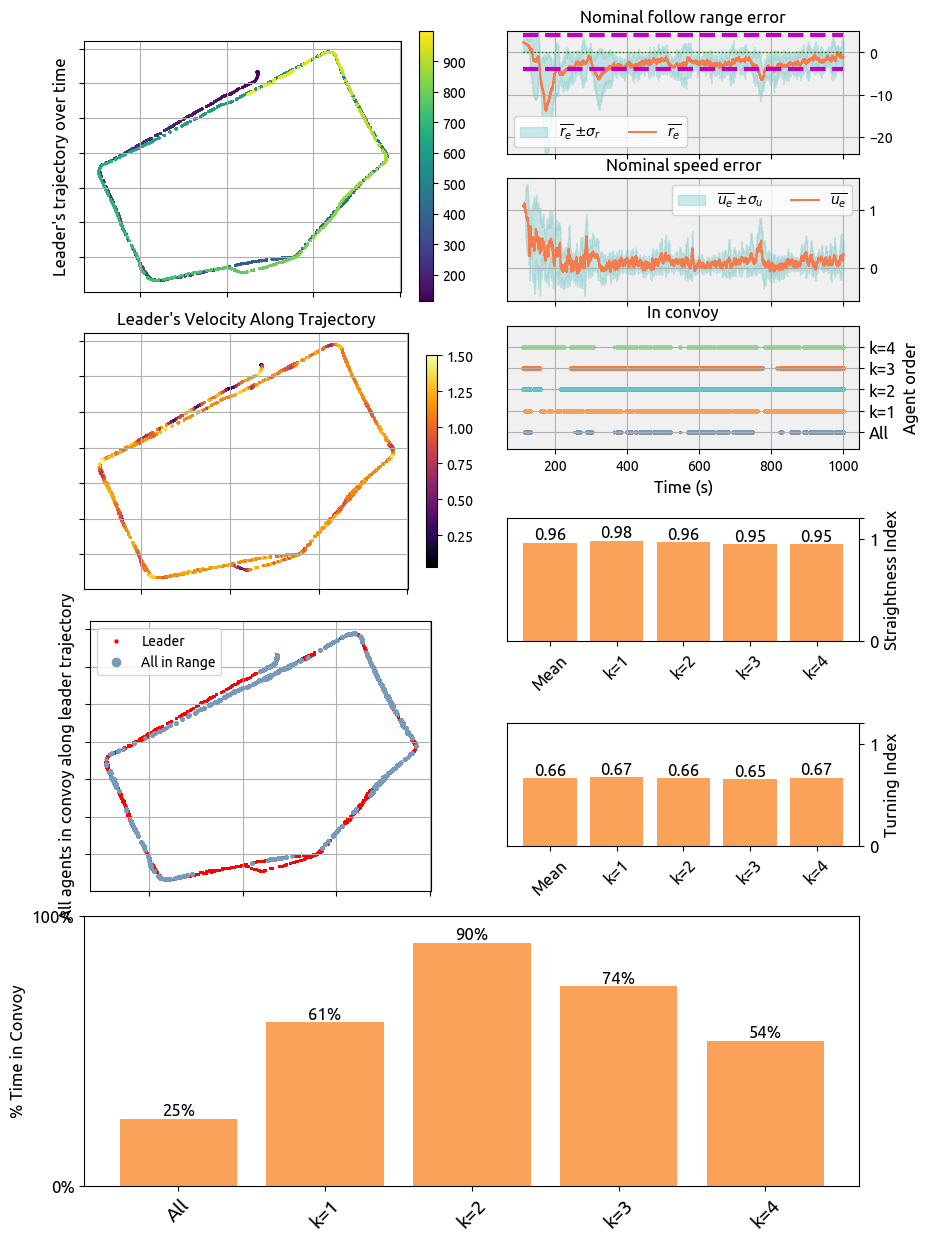

In [258]:
###### <Detailed analysis driven plot>
fig_det = plt.figure()
fig_det.set_figheight(15)
fig_det.set_figwidth(10)

### Left hand side
#Leader's track w/rt to time
ax_leader_det = plt.subplot2grid(shape=(8,2),loc=(0,0),rowspan=2,colspan=1)

ax_leader_det.xaxis.set_label_position("top")
#ax_leader_det.xaxis.tick_top()

#Leader's velocity w/rt to time
ax_leader_vel_det = plt.subplot2grid(shape=(8,2),loc=(2,0),rowspan=2,colspan=1,sharex=ax_leader_det)

#Leader's where in the leaders track all the agents are in the convoy
ax_leader_incnvy_det = plt.subplot2grid(shape=(8,2),loc=(4,0),rowspan=2,colspan=1,sharex=ax_leader_det)

### Right hand side (all time sync'd)

#Deviation from IDF
ax_idf_det = plt.subplot2grid(shape=(8,2),loc=(0,1),rowspan=1,colspan=1)
ax_idf_det.yaxis.set_label_position("right")
ax_idf_det.yaxis.tick_right()

#Speed differences for all agents (communicate lag and stability roughly) w/rt time
ax_des_speed_det = plt.subplot2grid(shape=(8,2),loc=(1,1),rowspan=1,colspan=1)
ax_des_speed_det.yaxis.set_label_position("right")
ax_des_speed_det.yaxis.tick_right()

#Plot horizontal bands for the times in which all the agents are in a convoy
ax_in_convoy_det = plt.subplot2grid(shape=(8,2),loc=(2,1),rowspan=1,colspan=1)
ax_in_convoy_det.yaxis.set_label_position("right")
ax_in_convoy_det.yaxis.tick_right()

# straightness index barplot
ax_si_det = plt.subplot2grid(shape=(8,2),loc=(3,1),rowspan=1,colspan=1)
ax_si_det.yaxis.set_label_position("right")
ax_si_det.yaxis.tick_right()

# turning index bar plot
ax_ti_det = plt.subplot2grid(shape=(8,2),loc=(5,1),rowspan=1,colspan=1)
ax_ti_det.yaxis.set_label_position("right")
ax_ti_det.yaxis.tick_right()


## Bottom
#Plot a histogram of the agents name/order and the total time they spent in a convoy
ax_perc_in_convoy_det = plt.subplot2grid(shape=(8,2),loc=(6,0),rowspan=2,colspan=2)


###PLOTTING LEFT SIDE
#Plot the leaders trajectory w/rt to time and the times in which the collection of systems is in a convoy
ln = all_general_info["leader"]
leader_x = all_data_df[f"{ln}_x"]
leader_y = all_data_df[f"{ln}_y"]
sc = ax_leader_det.scatter(leader_x,leader_y,c=all_data_df.index,s=0.5)
cbar = plt.colorbar(sc,fraction=0.05)
cbar.ax.tick_params(labelsize=10)
ax_leader_det.set_aspect('equal',adjustable='box')
#ax_leader_det.set_xlabel("Easting (m)",fontsize=10)
#ax_leader_det.set_ylabel("Northing (m)",fontsize=10)
ax_leader_det.set_ylabel("Leader's trajectory over time",fontsize=12)
tix = ax_leader_det.get_yticks()
ax_leader_det.set_yticklabels(["" for _ in tix])

ax_leader_det.grid(True)

# Along the leaders trajectory plot when all agents are in a convoy
ln = all_general_info["leader"]
leader_x = all_data_df[f"{ln}_x"]
leader_y = all_data_df[f"{ln}_y"]
sc = ax_leader_incnvy_det.scatter(leader_x,leader_y,s=0.5, color="r", label="Leader")
ax_leader_incnvy_det.set_aspect('equal',adjustable='box')
#ax_leader_incnvy_det.set_xlabel("Easting (m)",fontsize=10)
#ax_leader_incnvy_det.set_ylabel("Northing (m)",fontsize=10)
ax_leader_incnvy_det.set_ylabel("All agents in convoy along leader trajectory",fontsize=12)

#get the indices in which all the agents are in a successful convoy
team_convoying = (all_data_df["all_in_range"] == True)
good_convoy_x = leader_x[team_convoying]
good_convoy_y = leader_y[team_convoying]
ax_leader_incnvy_det.plot(good_convoy_x, good_convoy_y,
                linestyle="None",
                marker='o',
                markersize=2,
                markeredgecolor="#789ABC", ##789ABC #84c92a
                markerfacecolor='#789ABC',
                label="All in Range")

ax_leader_incnvy_det.legend(markerscale=3)

ax_leader_incnvy_det.grid(True)

ax_leader_incnvy_det.set_xticklabels([])
ax_leader_incnvy_det.set_yticklabels([])


#Plot the leaders velocity along the trajectory w/rt to time and the times in which the collection of systems is in a convoy
ln = all_general_info["leader"]
leader_x = all_data_df[f"{ln}_x"]
leader_y = all_data_df[f"{ln}_y"]
sc = ax_leader_vel_det.scatter(leader_x,leader_y,c=all_data_df[f"{ln}_spd"],s=0.5,cmap="inferno")
cbar2 = plt.colorbar(sc,fraction=0.03)
cbar2.ax.tick_params(labelsize=10)
ax_leader_vel_det.set_aspect('equal',adjustable='box')
ax_leader_vel_det.set_title("Leader's Velocity Along Trajectory",fontsize=12)
ax_leader_vel_det.grid(True)

# Calculating the mean speed
#mean_speed = all_data_df[f"{ln}_spd"].mean()

# Directly use the color bar's normalization to find the correct position
#mean_position = cbar2.norm(mean_speed)+0.6

# Add a marker for the mean value on the color bar
#cbar2.ax.axhline(mean_position, color='white', linestyle='--', linewidth=2)

ax_leader_vel_det.set_xticklabels([])
ax_leader_vel_det.set_yticklabels([])

def move_axis_to_left(ax, shift_amount):
    pos = ax.get_position()
    new_pos = [pos.x0 - shift_amount, pos.y0, pos.width, pos.height]
    ax.set_position(new_pos)
    
if tall_plot:
    move_axis_to_left(ax_leader_det, 0.02+0.05)
    move_axis_to_left(ax_leader_vel_det, 0.03+0.05)
    move_axis_to_left(ax_leader_incnvy_det, -0.05+0.05)
    ax_leader_incnvy_det.legend(markerscale=3,
                                bbox_to_anchor=(1.1,0.5))


#### PLOTTING RIGHT SIDE

# Distance to target
legend = []

ers = pd.DataFrame()
for n in agent_names:
    if n == all_general_info["leader"]:
        continue
    all_data_df[f"{n}_trgt_err"] = 10 - all_data_df[f"{n}_trgt_rng"]
    ers[f"{n}_trgt_err"] = all_data_df[f"{n}_trgt_err"]
    
mean = ers.mean(axis=1)
std = ers.std(axis=1)

ax_idf_det.fill_between(ers.index, mean - std, mean + std, color='#5FBFC0', alpha=0.3,label="$\overline{r_e}$ $\pm \sigma_r$")
sns.lineplot(data=mean,markersize=0.3,ax=ax_idf_det,color='#F37B4D',ci=None,label="$\overline{r_e}$")
ax_idf_det.legend(ncols=2)

ax_idf_det.set_title("Nominal follow range error",fontsize=12)
ax_idf_det.set_xticklabels([])
ax_idf_det.set_ylim([-24, 5])
ax_idf_det.set_xlabel("")
ax_idf_det.grid(True)
ax_idf_det.set_facecolor("#f0f0f0")

lr = [t[0], t[-1]]

if analysis_type == "cc":
    #ax_idf_det.plot(lr,(agent_info[n]["slower_rng"]-agent_info[n]["ideal_rng"])*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_idf_det.plot(lr,(4)*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_idf_det.plot(lr,0*np.ones([2,1]),linestyle=":",c="g",linewidth=1)
    #ax_idf_det.plot(lr,(agent_info[n]["full_lag_rng"]-agent_info[n]["ideal_rng"])*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_idf_det.plot(lr,(-4)*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
else:
    ax_idf_det.plot(lr,(4)*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_idf_det.plot(lr,0*np.ones([2,1]),linestyle=":",c="g",linewidth=1)
    ax_idf_det.plot(lr,(-4)*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
       
# Speeds

ers_spd = pd.DataFrame()
for n in agent_names:
    ers_spd[f"{n}_spd_err"] = desired_speed_fm - all_data_df[f"{n}_spd"]
    
mean = ers_spd.mean(axis=1)
std = ers_spd.std(axis=1)

#ax_des_speed_det.fill_between(ers.index, mean - std, mean + std, color='blue', alpha=0.3)

ax_des_speed_det.fill_between(ers.index, mean - std, mean + std, color='#5FBFC0', alpha=0.3,label="$\overline{u_e}$ $\pm \sigma_u$")
sns.lineplot(data=mean,ax=ax_des_speed_det,color='#F37B4D',ci=None,label="$\overline{u_e}$")
ax_des_speed_det.legend(ncols=2)


ax_des_speed_det.set_title("Nominal speed error",fontsize=12)
ax_des_speed_det.set_xticklabels([])
ax_des_speed_det.set_xlabel("")
ax_des_speed_det.set_facecolor("#f0f0f0")

#ax_des_speed_det.set_xticks(np.linspace(0,2,4))

ax_des_speed_det.grid(True)

# In convoy bands
        
#The Y axis is the order of the agents, the collective convoy is idx 0
legend_markers2 = []
max_order = 0
i = 0
for k,v in agent_info.items():
    i=i+1
    if k == all_general_info['leader']:
        continue
    order = all_general_info['ordering'][k]
    if order > max_order:
        max_order = order
    ax_in_convoy_det.scatter(t,all_data_df[f"{k}_in_rng"]*order,s=2,color=themed_colors[i])
    legend_markers2.append(f"{order}")
    
legend_markers2.append(f"All")
ax_in_convoy_det.scatter(t,all_data_df["all_in_range"],s=2,color="#789ABC")

ax_in_convoy_det.set_ylim([0.2,max_order+1])
ax_in_convoy_det.grid(True)
ax_in_convoy_det.set_title("In convoy",fontsize=12)
ax_in_convoy_det.set_yticklabels(ax_in_convoy_det.get_yticklabels(),fontsize=12)
ax_in_convoy_det.set_ylabel("Agent order",fontsize=12)
ax_in_convoy_det.set_xlabel("Time (s)",fontsize=12)


ax_in_convoy_det.set_yticks([1,2,3,4,5])

ax_in_convoy_det.set_yticklabels(["All", "k=1", "k=2", "k=3", "k=4"])

ax_in_convoy_det.set_facecolor("#f0f0f0")


# Straightness index

x = ["all_agents"]
y = [straightness_index]

ordering_sortable = [(k,v) for k,v in all_general_info['ordering'].items()]
ordering = sorted(ordering_sortable,key=lambda k: k[1])
rl = dict([(v,k) for k,v in all_general_info['ordering'].items()])

x.extend([f"{k}_{v}" for k,v in ordering if k != ln])
y.extend([agent_straightnesses[rl[v]] for k,v in ordering if k != ln])


barplot = ax_si_det.bar(x,y,color="#FAA15A")
ax_si_det.set_xticklabels(["Mean", "k=1", "k=2", "k=3", "k=4"],rotation=45,fontsize=12)

ax_si_det.set_ylabel("Straightness Index",fontsize=12)
ax_si_det.set_yticks([0,1,1.2])


ax_si_det.bar_label(barplot, [f"{p:0.2f}" for p in y],fontsize=12)

ax_si_det.set_yticklabels(["0", "1", " "],fontsize=12)
ax_si_det.grid(False)

pos = ax_si_det.get_position()

new_pos = [pos.x0, pos.y0-0.03, pos.width, pos.height]
ax_si_det.set_position(new_pos)



# Turning index

x = ["all_agents"]
y = [turn_index]

ordering_sortable = [(k,v) for k,v in all_general_info['ordering'].items()]
ordering = sorted(ordering_sortable,key=lambda k: k[1])
rl = dict([(v,k) for k,v in all_general_info['ordering'].items()])

x.extend([f"{k}_{v}" for k,v in ordering if k != ln])
y.extend([agent_turninesses[rl[v]] for k,v in ordering if k != ln])


barplot = ax_ti_det.bar(x,y,color="#FAA15A")
ax_ti_det.set_xticklabels(["Mean", "k=1", "k=2", "k=3", "k=4"],rotation=45,fontsize=12)

ax_ti_det.set_ylabel("Turning Index",fontsize=12)
ax_ti_det.set_yticks([0,1,1.2])

ax_ti_det.bar_label(barplot, [f"{p:0.2f}" for p in y],fontsize=12)

ax_ti_det.set_yticklabels(["0", "1", ""],fontsize=12)
ax_ti_det.grid(False)

pos = ax_ti_det.get_position()

new_pos = [pos.x0, pos.y0+0.03, pos.width, pos.height]
ax_ti_det.set_position(new_pos)



#lr = [t[0], t[-1]]

#Now plot a histogram of the total time each agent spent within a histogram
#Sort the order they are plotted by the order in which they are in
# all_agents_sum, follower_1, follower_2, ...



total_time_in_convoy = dict()
mission_duration = all_data_df.index[-1]-all_data_df.index[0]


for a in agent_names:
    if a == all_general_info['leader']:
        continue
    #Take differences in time for all measurements, for all cases in which this agent is also in a convoy, take the cummulative time of the 
    a_in_convoy = all_data_df[f"{a}_in_rng"]
    iic = np.array(t_diff[a_in_convoy])
    iic = iic[~np.isnan(iic)] 
    total_time_in_convoy[a] = iic.sum()/mission_duration
all_in_convoy = all_data_df[f"all_in_range"] 
total_time_in_convoy['all'] = np.array(t_diff[all_in_convoy]).sum()/mission_duration



#### PLOTTING BOTTOM
# Plotting the % time in which an agent is in a convoy w/rt mission duration

x = ["all_agents"]
y = [total_time_in_convoy['all']]

ordering_sortable = [(k,v) for k,v in all_general_info['ordering'].items()]
ordering = sorted(ordering_sortable,key=lambda k: k[1])
rl = dict([(v,k) for k,v in all_general_info['ordering'].items()])

x.extend([f"{k}_{v}" for k,v in ordering if k != ln])
y.extend([total_time_in_convoy[rl[v]] for k,v in ordering if k != ln])

barplot = ax_perc_in_convoy_det.bar(x,y,color="#FAA15A")
ax_perc_in_convoy_det.set_xticklabels(["All", "k=1", "k=2", "k=3", "k=4"],rotation=45,fontsize=14)

ax_perc_in_convoy_det.set_ylabel("% Time in Convoy",fontsize=12)
ax_perc_in_convoy_det.set_yticks(np.linspace(-0.1,1.1,2).round())

ax_perc_in_convoy_det.bar_label(barplot, [f"{p*100:0.0f}%" for p in y],fontsize=12)

ax_perc_in_convoy_det.set_yticklabels(["0%", "100%"],fontsize=12)
ax_perc_in_convoy_det.grid(False)


#ax_heading_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
#ax_spd_chngs_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )
#ax_rng_to_trg_det.tick_params(labelleft=True, labelbottom=False, left=False, right=False )

plt.savefig(f"{output_directory}{mission_hash}_det.png", dpi=150)
plt.show()
plt.close()
###### <Detailed analysis driven plot>

###### </PLOT ALL THE DATA>

abe
deb
ben
fin


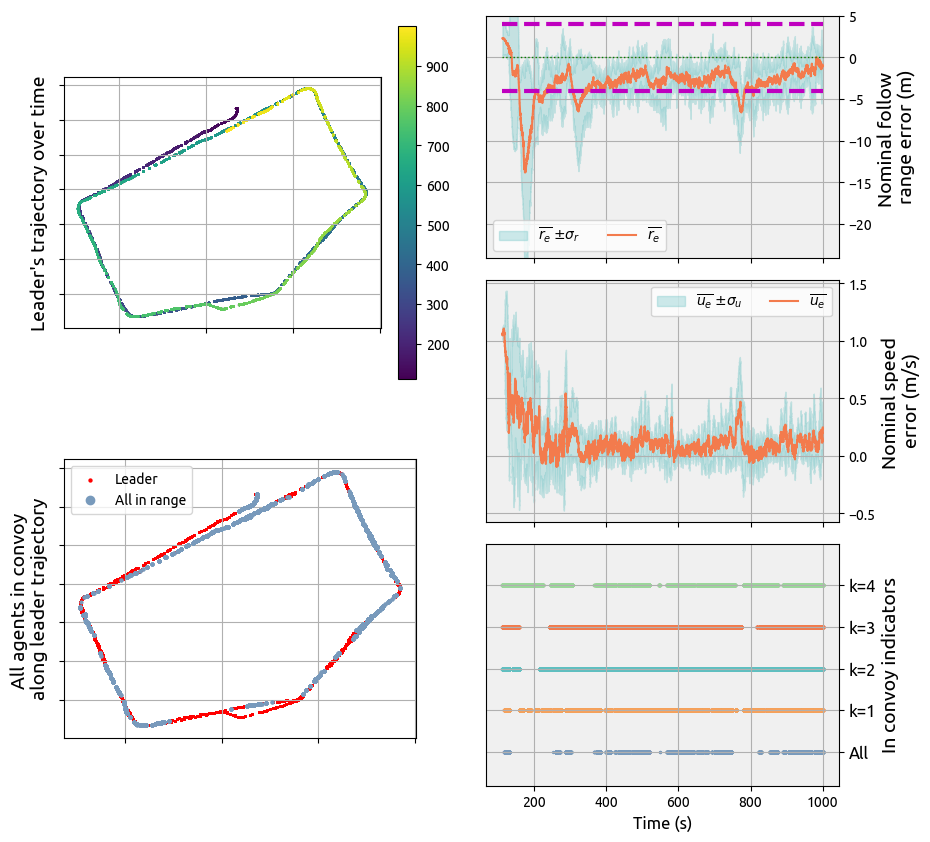

In [259]:
###### <Detailed analysis driven plot 3>
fig_det = plt.figure()
fig_det.set_figheight(10)
fig_det.set_figwidth(10)

### Left hand side
#Leader's track w/rt to time
ax_leader_det = plt.subplot2grid(shape=(6,2),loc=(0,0),rowspan=3,colspan=1)

ax_leader_det.xaxis.set_label_position("top")
#ax_leader_det.xaxis.tick_top()

#Leader's where in the leaders track all the agents are in the convoy
ax_leader_incnvy_det = plt.subplot2grid(shape=(6,2),loc=(3,0),rowspan=3,colspan=1,sharex=ax_leader_det)

### Right hand side (all time sync'd)

#Deviation from IDF
ax_idf_det = plt.subplot2grid(shape=(6,2),loc=(0,1),rowspan=2,colspan=1)
ax_idf_det.yaxis.set_label_position("right")
ax_idf_det.yaxis.tick_right()

#Speed differences for all agents (communicate lag and stability roughly) w/rt time
ax_des_speed_det = plt.subplot2grid(shape=(6,2),loc=(2,1),rowspan=2,colspan=1)
ax_des_speed_det.yaxis.set_label_position("right")
ax_des_speed_det.yaxis.tick_right()

#Plot horizontal bands for the times in which all the agents are in a convoy
ax_in_convoy_det = plt.subplot2grid(shape=(6,2),loc=(4,1),rowspan=2,colspan=1)
ax_in_convoy_det.yaxis.set_label_position("right")
ax_in_convoy_det.yaxis.tick_right()


###PLOTTING LEFT SIDE
#Plot the leaders trajectory w/rt to time and the times in which the collection of systems is in a convoy
ln = all_general_info["leader"]
leader_x = all_data_df[f"{ln}_x"]
leader_y = all_data_df[f"{ln}_y"]
sc = ax_leader_det.scatter(leader_x,leader_y,c=all_data_df.index,s=0.5)
cbar = plt.colorbar(sc,fraction=0.05)
if tall_plot:
    cbar = plt.colorbar(sc,fraction=0.05,pad=0.0)

###<cbar>
if tall_plot:
    pos = cbar.ax.get_position()

    new_pos = [pos.x0 - 0.05, pos.y0, pos.width, pos.height]  # Adjust the 0.05 as needed to shift

    cbar.ax.set_position(new_pos)

###</cbar>


cbar.ax.tick_params(labelsize=10)

ax_leader_det.set_aspect('equal',adjustable='box')
ax_leader_det.set_ylabel("Leader's trajectory over time",fontsize=14)
tix = ax_leader_det.get_yticks()
ax_leader_det.set_yticklabels(["" for _ in tix])

ax_leader_det.grid(True)

# Along the leaders trajectory plot when all agents are in a convoy
ln = all_general_info["leader"]
leader_x = all_data_df[f"{ln}_x"]
leader_y = all_data_df[f"{ln}_y"]
sc = ax_leader_incnvy_det.scatter(leader_x,leader_y,s=0.5, color="r", label="Leader")
ax_leader_incnvy_det.set_aspect('equal',adjustable='box')
#ax_leader_incnvy_det.set_xlabel("Easting (m)",fontsize=10)
#ax_leader_incnvy_det.set_ylabel("Northing (m)",fontsize=10)
ax_leader_incnvy_det.set_ylabel("All agents in convoy \nalong leader trajectory",fontsize=14)

#get the indices in which all the agents are in a successful convoy
team_convoying = (all_data_df["all_in_range"] == True)
good_convoy_x = leader_x[team_convoying]
good_convoy_y = leader_y[team_convoying]
ax_leader_incnvy_det.plot(good_convoy_x, good_convoy_y,
                linestyle="None",
                marker='o',
                markersize=2,
                markeredgecolor="#789ABC", ##789ABC #84c92a
                markerfacecolor='#789ABC',
                label="All in range")

ax_leader_incnvy_det.legend(markerscale=3)

ax_leader_incnvy_det.grid(True)

ax_leader_incnvy_det.set_xticklabels([])
ax_leader_incnvy_det.set_yticklabels([])

def move_axis_to_left(ax, shift_amount):
    pos = ax.get_position()
    new_pos = [pos.x0 - shift_amount, pos.y0, pos.width, pos.height]
    ax.set_position(new_pos)
    
if tall_plot:
    move_axis_to_left(ax_leader_det, 0.02+0.05)
    move_axis_to_left(ax_leader_incnvy_det, 0.00)
    ax_leader_incnvy_det.legend(markerscale=3,
                                bbox_to_anchor=(1.1,0.5))


#### PLOTTING RIGHT SIDE

# Distance to target
legend = []

ers = pd.DataFrame()
for n in agent_names:
    if n == all_general_info["leader"]:
        continue
    all_data_df[f"{n}_trgt_err"] = 10 - all_data_df[f"{n}_trgt_rng"]
    ers[f"{n}_trgt_err"] = all_data_df[f"{n}_trgt_err"]
    
mean = ers.mean(axis=1)
std = ers.std(axis=1)

ax_idf_det.fill_between(ers.index, mean - std, mean + std, color='#5FBFC0', alpha=0.3,label="$\overline{r_e}$ $\pm \sigma_r$")
sns.lineplot(data=mean,markersize=0.3,ax=ax_idf_det,color='#F37B4D',ci=None,label="$\overline{r_e}$")
ax_idf_det.legend(ncols=2)

ax_idf_det.set_ylabel("Nominal follow \nrange error (m)",fontsize=14)
ax_idf_det.set_xticklabels([])
ax_idf_det.set_ylim([-24, 5])
ax_idf_det.set_xlabel("")
ax_idf_det.grid(True)
ax_idf_det.set_facecolor("#f0f0f0")

lr = [t[0], t[-1]]

if analysis_type == "cc":
    #ax_idf_det.plot(lr,(agent_info[n]["slower_rng"]-agent_info[n]["ideal_rng"])*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_idf_det.plot(lr,(4)*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_idf_det.plot(lr,0*np.ones([2,1]),linestyle=":",c="g",linewidth=1)
    #ax_idf_det.plot(lr,(agent_info[n]["full_lag_rng"]-agent_info[n]["ideal_rng"])*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_idf_det.plot(lr,(-4)*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
else:
    ax_idf_det.plot(lr,(4)*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
    ax_idf_det.plot(lr,0*np.ones([2,1]),linestyle=":",c="g",linewidth=1)
    ax_idf_det.plot(lr,(-4)*np.ones([2,1]),linestyle="--",c="m",linewidth=3)
       
# Speeds

ers_spd = pd.DataFrame()
for n in agent_names:
    ers_spd[f"{n}_spd_err"] = desired_speed_fm - all_data_df[f"{n}_spd"]
    
mean = ers_spd.mean(axis=1)
std = ers_spd.std(axis=1)

#ax_des_speed_det.fill_between(ers.index, mean - std, mean + std, color='blue', alpha=0.3)

ax_des_speed_det.fill_between(ers.index, mean - std, mean + std, color='#5FBFC0', alpha=0.3,label="$\overline{u_e}$ $\pm \sigma_u$")
sns.lineplot(data=mean,ax=ax_des_speed_det,color='#F37B4D',ci=None,label="$\overline{u_e}$")
ax_des_speed_det.legend(ncols=2)


ax_des_speed_det.set_ylabel("Nominal speed \nerror (m/s)",fontsize=14)
ax_des_speed_det.set_xticklabels([])
ax_des_speed_det.set_xlabel("")
ax_des_speed_det.set_facecolor("#f0f0f0")

#ax_des_speed_det.set_xticks(np.linspace(0,2,4))

ax_des_speed_det.grid(True)

# In convoy bands
        
#The Y axis is the order of the agents, the collective convoy is idx 0
legend_markers2 = []
max_order = 0
i = 0
for k,v in agent_info.items():
    i=i+1
    if k == all_general_info['leader']:
        continue
    order = all_general_info['ordering'][k]
    if order > max_order:
        max_order = order
    print(k)
    ax_in_convoy_det.scatter(t,all_data_df[f"{k}_in_rng"]*order,s=2,color=themed_colors[i])
    legend_markers2.append(f"{order}")
    
legend_markers2.append(f"All")
ax_in_convoy_det.scatter(t,all_data_df["all_in_range"],s=2,color="#789ABC")

ax_in_convoy_det.set_ylim([0.2,max_order+1])
ax_in_convoy_det.grid(True)
ax_in_convoy_det.set_yticklabels(ax_in_convoy_det.get_yticklabels(),fontsize=12)
ax_in_convoy_det.set_ylabel("In convoy indicators",fontsize=14)
ax_in_convoy_det.set_xlabel("Time (s)",fontsize=12)

ax_in_convoy_det.set_yticks([1,2,3,4,5])

ax_in_convoy_det.set_yticklabels(["All", "k=1", "k=2", "k=3", "k=4"])

ax_in_convoy_det.set_facecolor("#f0f0f0")

plt.savefig(f"{output_directory}{mission_hash}_det2.png", dpi=150)
plt.show()
plt.close()
###### <Detailed analysis driven plot>

###### </PLOT ALL THE DATA>